# Classify_df

This notebook will process all the images from the input/target dataset. It will use the json file to map the IDs to their original filenames. Then, it will search for all the crops belonging to these images and use all the models to predict whether each crop is noise or a cell. After the prediction, it will store the results in the corresponding CSV file for each image.

The output will be a folder for each model used. Within each folder, a CSV file will be created for each image, containing information about the bounding boxes of each crop and its classification (cell or noise).

### Imports

In [12]:
import os
import sys
import json
import math

import cv2 as cv
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from shapely.geometry import Polygon
from tensorflow.keras.applications import efficientnet_v2, convnext

### Definitions

In [13]:
sys.path.insert(0, "../../")
from config import MEDIA_PATH, CROPPED_PATH, MODELS_PATH, RESULTS_PATH

# Specific paths
IMAGES_PATH = os.path.join(MEDIA_PATH, 'images', 'ina', 'tagged_images', 'input')
CROPS_PATH = os.path.join(CROPPED_PATH, 'ina', 'images')
CSV_PATH = os.path.join(CROPPED_PATH, 'ina', 'data')
JSON_PATH = os.path.join(MEDIA_PATH, 'images', 'ina', 'tagged_images', 'corte-27-02-2024.json')
MODELS_PATH = os.path.join(MODELS_PATH, 'supervised')

### Functions

In [14]:
def predict_cell(model,model_name, image_path, images_batch, color_type):
  """
  Given an image batch it returns the predictions of the batch with the given model.

  Args:
    model: keras model to use.
    image_path: path to the folder where the images are.
    images_batch: list of the image names to include in the batch

  Returns:
    A list of predictions.
  """

  images = []
  for image in images_batch:
      img = cv.imread(os.path.join(image_path,image), color_type)

      if model_name == 'model_EfficientNetB0.keras':
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (224, 224))
        img = efficientnet_v2.preprocess_input(img)
        images.append(img)

      elif model_name == "model_ConvNeXtTiny.keras":
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (224, 224))
        img = convnext.preprocess_input(img)
        images.append(img)

      else:
        img = cv.resize(img, (128, 128))
        img = img / 255.0
        images.append(img)


  batch = np.stack(images)
  if color_type == cv.IMREAD_GRAYSCALE:\
    # Add missing channel
    batch = np.expand_dims(batch, axis=-1).astype(np.float32)

  prediction = model.predict(batch, verbose=0)
  prediction = tf.nn.softmax(prediction, axis=-1)
  return prediction


def find_image_name_and_id(data, image_name):
  """
  Given a list of objects it searches the file_name from the id.

  Args:
    data: list of objects to search from.
    id: id of the file name to return.

  Returns:
    The file name of the image id.
  """
  #First i have to check wether the image_name is an id or a file name (ex: 331 or 004_000001.jpg)
  if(image_name.isnumeric()):
    id = int(image_name)
    for img in data:
        if img['id'] == id:
            real_name, _ = os.path.splitext(img['file_name'])
            return real_name, id
  else:
    for img in data:
        real_name = image_name
        if real_name in img['file_name']:
            id = int(img['id'])
            return real_name, id

def get_cells_bbox(data, id):
  """
  Given a list of objects it returns a list of bounding boxes for the given id.

  Args:
    data: list of objects to search from.
    id: id of the objetct to search.

  Returns:
    A list of bounding boxes.
  """
  return [cell['bbox'] for cell in data['annotations'] if cell['image_id'] == id]

def process_images_in_batches(string_list, batch_size=10):
  """
  Processes a list of strings in batches of a specified size.

  Args:
    string_list: The list of strings to process.
    batch_size: The size of each batch.

  Yields:
    A batch of strings.
  """
  for i in range(0, len(string_list), batch_size):
    batch_num = i // batch_size + 1  # Calculate batch number (1-indexed)
    yield batch_num, string_list[i:i + batch_size]

def bb_overlap_percentage(box1, box2):

    """
    Calculates the Intersection over Union (IoU) of two bounding boxes using Shapely.

    Args:
        box1: A tuple or list containing (x1, y1, width, height) of the first bounding box.
        box2: A tuple or list containing (x1, y1, width, height) of the second bounding box.

    Returns:
        The IoU value, a float between 0 and 1.
    """

    # Calculate box coordinates
    x1_min, y1_min, width1, height1 = box1
    x1_max = x1_min + width1
    y1_max = y1_min + height1
    x2_min, y2_min, width2, height2 = box2
    x2_max = x2_min + width2
    y2_max = y2_min + height2

    # Create polygons
    poly1 = Polygon([(x1_min, y1_min), (x1_max, y1_min), (x1_max, y1_max), (x1_min, y1_max)])
    poly2 = Polygon([(x2_min, y2_min), (x2_max, y2_min), (x2_max, y2_max), (x2_min, y2_max)])

    # Calculate intersection and union areas
    intersection = poly1.intersection(poly2).area
    union = poly1.union(poly2).area

    #print(poly1.area, poly2.area, intersection)

    return intersection / poly1.area if union > 0 else 0.0

def bbox_fully_contained(bbox1, bbox2):
    """
    Checks if bounding box 1 is fully contained within bounding box 2.

    Args:
        bbox1: A tuple (x1, y1, width1, height1) representing the first bounding box.
        bbox2: A tuple (x2, y2, width2, height2) representing the second bounding box.

    Returns:
        True if bbox1 is fully contained within bbox2, False otherwise.
    """

    # Calculate coordinates of bounding boxes
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    bbox1_coords = [(x1, y1), (x1 + w1, y1), (x1 + w1, y1 + h1), (x1, y1 + h1)]
    bbox2_coords = [(x2, y2), (x2 + w2, y2), (x2 + w2, y2 + h2), (x2, y2 + h2)]

    # Create Shapely polygons
    poly1 = Polygon(bbox1_coords)
    poly2 = Polygon(bbox2_coords)

    # Check if bbox1 is fully contained within bbox2
    return poly1.within(poly2)

def bbox_intercept(bbox, bbox_list, threshold=0):
  for idx, bbox_target in enumerate(bbox_list):
    if threshold > 0: # 0.75
      iou = bb_overlap_percentage(bbox, bbox_target)
      if iou >= threshold:
        return True, idx

    else:
      contained = bbox_fully_contained(bbox, bbox_target)
      if contained:
        return True, idx

  return False, -1

### Lists of elements to use

In [15]:
csvs = sorted(os.listdir(CSV_PATH)) #Paths to the csv of SAM detections of each image
crops = sorted(os.listdir(CROPS_PATH)) #Paths to the crops made from SAM detection of the full_images
models = sorted(os.listdir(MODELS_PATH)) #Models to use in the prediction
og_images = sorted(os.listdir(IMAGES_PATH)) #full_images from where the crops are made
with open(JSON_PATH, 'r') as f: #json with the information of the filename of the images
    data = json.load(f)

### Model prediction

In [16]:
first_pass = True
for model_idx, model in enumerate(models):


    base_model, ext = os.path.splitext(model)
    if '.keras' != ext:
        continue
    print(f'Testing model {base_model.split(".")[0]}')

    model_path=os.path.join(MODELS_PATH, model)
    loaded_model = keras.models.load_model(model_path)

    if loaded_model.input.shape[-1] == 1:
        color_type = cv.IMREAD_GRAYSCALE
    else:
        color_type = cv.IMREAD_COLOR


    output = os.path.join(RESULTS_PATH, "evaluated", base_model)

    if not os.path.exists(output): #Create dirs for each model used
        os.makedirs(output)

    tagged_images = list()
    for og_image_idx, og_image in enumerate(og_images):
        img_name, _ = os.path.splitext(og_image)
        real_name, img_name = find_image_name_and_id(data['images'], img_name) #Find the real image name from where the crops where made
        bboxes_coco =  get_cells_bbox(data, img_name) #Get all bboxes_coco from the tagged images
        if len(bboxes_coco) == 0:
            if first_pass:
                print(f"skipping {og_image} ({real_name}), no tags.")
            continue
        if not first_pass:
            tagged_images.append(og_image)

        images = sorted([crop for crop in crops if crop.startswith(real_name)]) #Get all the crops from that image
        df = pd.read_csv(os.path.join(CSV_PATH, f"{real_name}.csv")) #Read the csv of that image
        bboxes_sam = [tuple(map(int, row)) for row in df[['x', 'y', 'w', 'h']].values]
        df = df.rename(columns={'cell_id': 'cell_id_sam'})

        batch_size=30
        for idx, batch in process_images_in_batches(images, batch_size=batch_size): #Read the images in batch_size batches
            print(f"Model: {model} ({model_idx+1}/{len(models)}) - Image: {og_image} ({og_image_idx+1}/{len(og_images)}) - Batch {idx}/{math.ceil(len(images)/batch_size)}", end='\r')

            batch_prediction = predict_cell(loaded_model,model, image_path=CROPS_PATH, images_batch=batch, color_type=color_type)

            is_cell = 1-np.argmax(batch_prediction, axis=1).astype(bool)

            # For each image in the batch store the prediction in the csv toghether with the cell_id of the coco tags
            for idx, i in enumerate(batch):
                crop_name, _ = os.path.splitext(i)
                cell_id = crop_name.split('_')[2]

                mask = (df['cell_id_sam'] == int(cell_id)) & (df['image'] == real_name)
                filtered_df = df[mask]

                df.loc[mask, 'is_cell_sam'] = is_cell[idx]
                df.loc[mask, 'image'] = img_name
                x, y, w, h = filtered_df[['x', 'y', 'w', 'h']].values[0]
                intercept, cell_id_coco = bbox_intercept((x,y,w,h), bboxes_coco,0.75)
                df.loc[mask, 'cell_id_coco'] = int(cell_id_coco)
                df.loc[mask, 'is_cell_ground_truth'] = intercept

        #For each cell in coco i check if it was not detected by sam
        for idx, bbox_coco in enumerate(bboxes_coco):
            intercept, _ = bbox_intercept(bbox_coco, bboxes_sam)
            if not intercept:
                new_row = {'area': 0,'x':bbox_coco[0] ,'y':bbox_coco[1],'w':bbox_coco[2],'h':bbox_coco[3],
                            'bbox_area':bbox_coco[2]*bbox_coco[3],'image':img_name,'cell_id_sam':-1,
                            'is_cell_sam':False,'cell_id_coco':idx,'is_cell_ground_truth':True}
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

        # Configure the dataframe to store it
        df['cell_id_coco'] = df['cell_id_coco'].astype(int)
        df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
        df.to_csv(os.path.join(output, f"{img_name}.csv"))
    first_pass = False
    print("DONE\n-------------------------------------------------------------------------------------------")


Testing model supervised_Encoder_SSIM+MAE0


I0000 00:00:1746569253.662641   46372 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1077 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


I0000 00:00:1746569254.169694  123649 service.cc:152] XLA service 0x7d366400f950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746569254.169705  123649 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-05-06 19:07:34.174655: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746569254.216689  123649 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1746569254.651348  123649 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


DONEl: supervised_Encoder_SSIM+MAE0.keras (1/5) - Image: 392.png (58/58) - Batch 7/7
-------------------------------------------------------------------------------------------
Testing model supervised_Encoder_SSIM+MAE1
DONEl: supervised_Encoder_SSIM+MAE1.keras (2/5) - Image: 392.png (58/58) - Batch 7/7
-------------------------------------------------------------------------------------------
Testing model supervised_Encoder_SSIM+MAE2
DONEl: supervised_Encoder_SSIM+MAE2.keras (3/5) - Image: 392.png (58/58) - Batch 7/7
-------------------------------------------------------------------------------------------
Testing model supervised_Encoder_SSIM+MAE3
DONEl: supervised_Encoder_SSIM+MAE3.keras (4/5) - Image: 392.png (58/58) - Batch 7/7
-------------------------------------------------------------------------------------------
Testing model supervised_Encoder_SSIM+MAE4
DONEl: supervised_Encoder_SSIM+MAE4.keras (5/5) - Image: 392.png (58/58) - Batch 7/7
-----------------------------------

In [17]:
print(f"Tested images: {tagged_images}")

Tested images: ['331.png', '332.png', '333.png', '334.png', '335.png', '336.png', '337.png', '341.png', '342.png', '343.png', '344.png', '345.png', '346.png', '347.png', '348.png', '349.png', '350.png', '351.png', '352.png', '353.png', '354.png', '355.png', '356.png', '357.png', '358.png', '359.png', '360.png', '361.png', '362.png', '363.png', '364.png', '365.png', '366.png', '367.png', '368.png', '369.png', '370.png', '371.png', '372.png', '373.png', '374.png', '375.png', '376.png', '377.png', '378.png', '379.png', '380.png', '381.png', '382.png', '383.png', '384.png', '385.png', '386.png', '387.png', '389.png', '390.png', '391.png', '392.png']


#### Functions testing

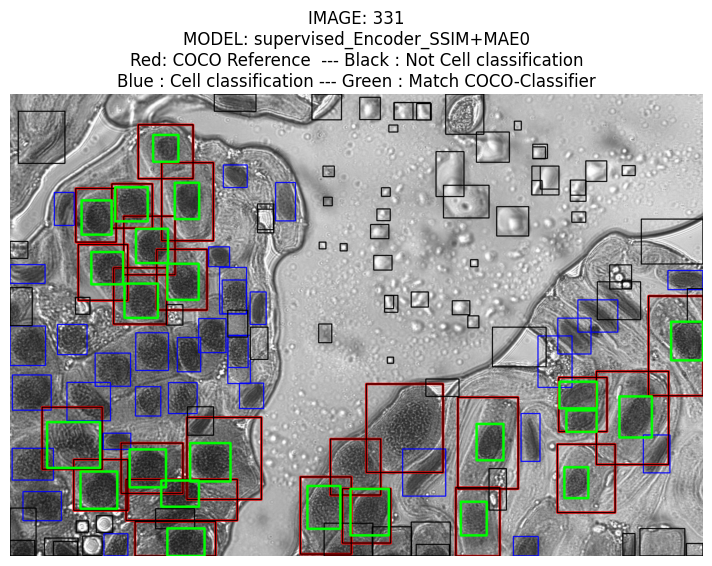

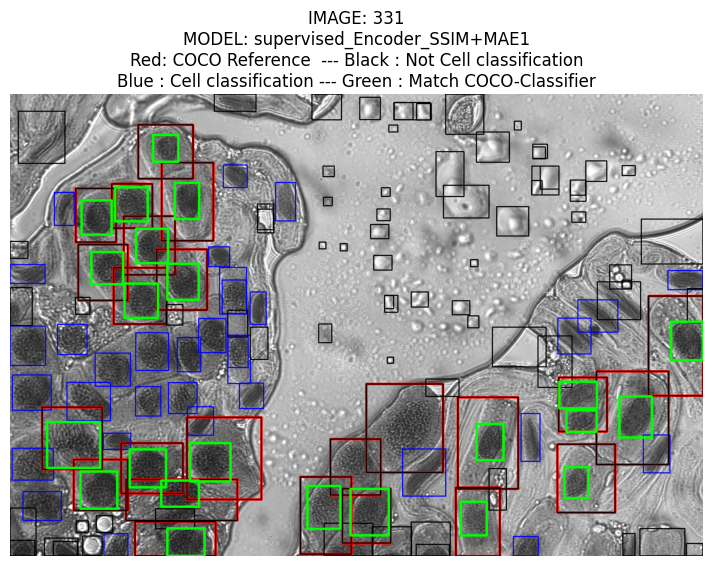

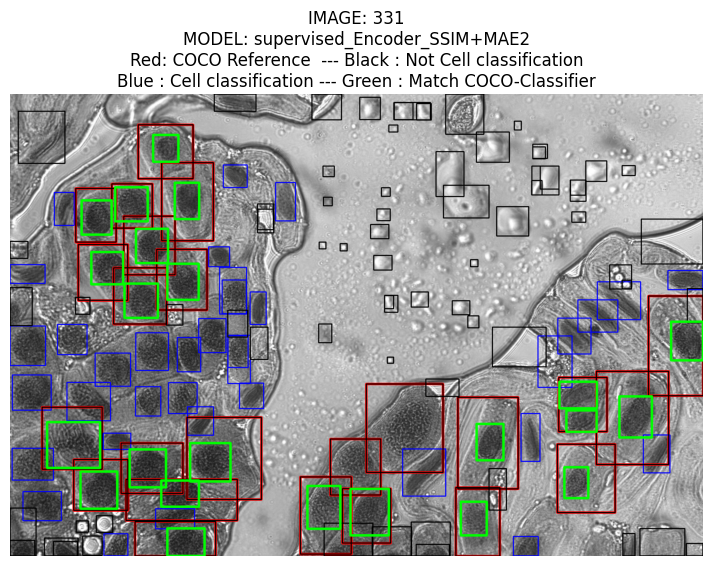

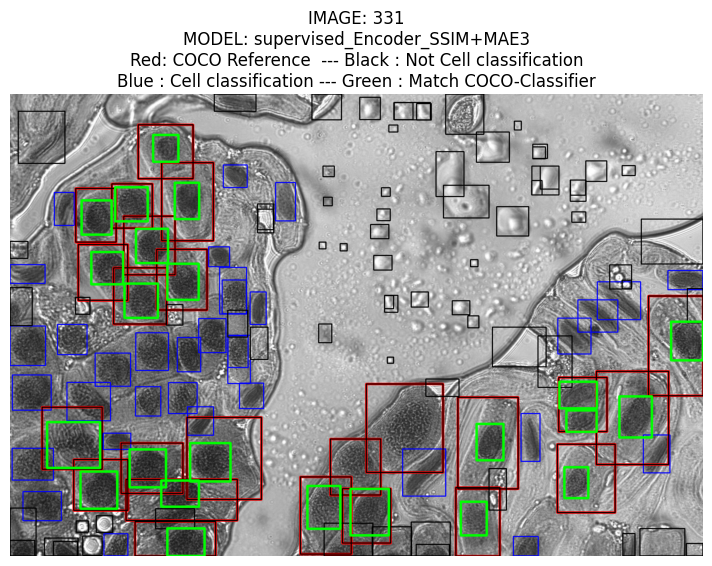

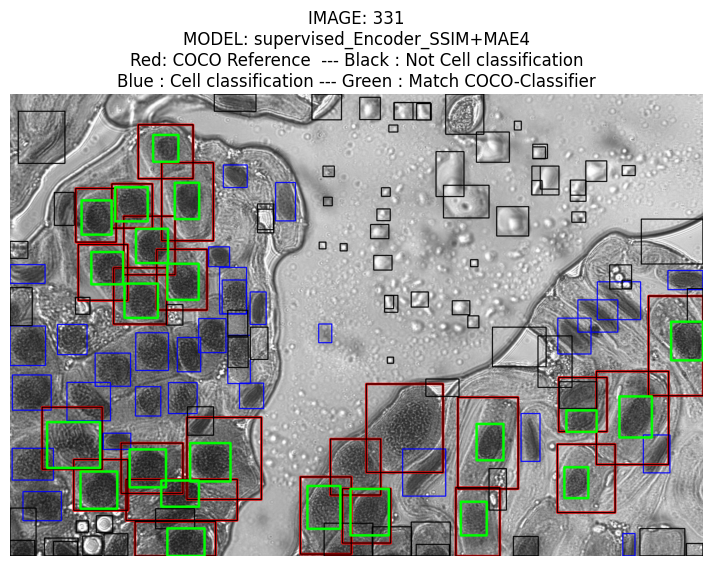

In [18]:
img_num=331
models_compare = ["supervised_Encoder_SSIM+MAE0", "supervised_Encoder_SSIM+MAE1", "supervised_Encoder_SSIM+MAE2", "supervised_Encoder_SSIM+MAE3", "supervised_Encoder_SSIM+MAE4"]

for this_model in models_compare:
    df = pd.read_csv(os.path.join(RESULTS_PATH, "evaluated", this_model, f"{str(img_num)}.csv"))
    bboxes_og =  get_cells_bbox(data, img_num)
    df_cells = df.loc[df['is_cell_sam']==True]
    bboxes_sam_cells = [tuple(map(int, row)) for row in df_cells[['x', 'y', 'w', 'h']].values]
    df_not = df.loc[df['is_cell_sam']==False]
    bboxes_sam_not = [tuple(map(int, row)) for row in df_not[['x', 'y', 'w', 'h']].values]
    img = cv.imread(os.path.join(IMAGES_PATH, f'{str(img_num)}.png'))

    
    for bbox in bboxes_og:
        x, y, w, h = bbox
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
        cv.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 10)

    for bbox in bboxes_sam_cells:
        x, y, w, h = bbox
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
        cv.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
    for bbox in bboxes_sam_not:
        x, y, w, h = bbox
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
        cv.rectangle(img, (x1, y1), (x2, y2), (0, 0, 0), 3)
    
    for bbox_sam in bboxes_sam_cells:
        for bbox_og in bboxes_og:
            # if bb_overlap_percentage(bbox_sam, bbox_og) >= 0.2:
            # if bbox_fully_contained(bbox_sam, bbox_og):
            if bbox_fully_contained(bbox_sam, bbox_og) or bb_overlap_percentage(bbox_sam, bbox_og) >= 0.75:
                # x, y, w, h = bbox_og
                x, y, w, h = bbox_sam
                x1, y1 = int(x), int(y)
                x2, y2 = int(x + w), int(y + h)
                cv.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 10)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"IMAGE: {img_num}\nMODEL: {this_model}\nRed: COCO Reference  --- Black : Not Cell classification\nBlue : Cell classification --- Green : Match COCO-Classifier")
    plt.show()


# Results

In [19]:
for model_idx, model in enumerate(models):
    #output = os.path.join(RESULTS_PATH, base_model)
    #if not os.path.exists(output):
    #    continue
    for og_image_idx, og_image in enumerate(og_images):
        df = pd.read_csv(os.path.join(output, f"{img_name}.csv"))


In [20]:
df

,Unnamed: 0,area,x,y,w,h,bbox_area,image,cell_id_sam,is_cell_sam,cell_id_coco,is_cell_ground_truth
0,0,37780,80.0,1819.0,202.0,228.0,46056.0,392,0,0.0,30,True
1,1,23444,1542.0,1927.0,250.0,120.0,30000.0,392,1,0.0,43,True
2,2,57410,1238.0,1032.0,266.0,289.0,76874.0,392,2,1.0,39,True
3,3,50979,1020.0,1089.0,213.0,295.0,62835.0,392,3,0.0,38,True
4,4,26447,928.0,809.0,182.0,184.0,33488.0,392,4,0.0,-1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
247,247,0,2464.0,49.0,476.0,259.0,123284.0,392,-1,0.0,66,True
248,248,0,2099.0,703.0,273.0,179.0,48867.0,392,-1,0.0,68,True
249,249,0,2345.0,684.0,377.0,170.0,64090.0,392,-1,0.0,69,True
250,250,0,2780.0,771.0,291.0,222.0,64602.0,392,-1,0.0,70,True
